# EDA Prior To Fitting a Regression Model

Learn about recommended EDA steps before fitting a regression model.

## Introduction

- Before fitting any model, it is often important to conduct an exploratory data analysis (EDA) in order to check assumptions, inspect the data for anomalies (such as missing, duplicated, or mis-coded data), and inform feature selection/transformation. 
- In this article, we will use pandas to explore some of the EDA techniques that are generally employed prior to fitting a regression model.

## The Data

- For our example analysis, we’ve downloaded a dataset from [Kaggle](https://www.kaggle.com/datasets/cyaris/2016-mlb-season?select=baseball_reference_2016_clean.csv) which contains data on Major League Baseball (MLB) games from the 2016 season. 
- We’ve saved this data as a `DataFrame` named `bb`. 
- Suppose that we want to fit a linear regression to predict `attendance` using the following predictors:
    - `game_type` — is the game during the day or at night?
    - `day_of_week` — what day of the week did the game occur?
    - `temperature` — average game temperature (Fahrenheit).
    - `sky` — description of sky condition at the time of the game.
    - `total_runs` — total runs scored in the game.

## Preview the Dataset

- Any EDA process will probably begin by inspecting a subset of data. 
- For a pandas `DataFrame`, this can be done by using the `.head()` method:

In [81]:
import pandas as pd

In [82]:
bb = pd.read_csv("baseball_reference_2016_clean.csv")

all_columns = set(bb.columns)
keep_columns = {'attendance', 'game_type',  'day_of_week', 'temperature', 'sky', 'total_runs'}

bb.drop(all_columns - keep_columns, axis=1, inplace=True)
bb.total_runs = bb.total_runs.astype(object)
bb.temperature = bb.temperature.astype(object)

# Insert some missing values
bb.loc[6, "sky"] = 'Unknown'
bb.loc[6, "total_runs"] = '-'
bb.loc[7, "total_runs"] = 60
bb.loc[7, "temperature"] = 'Unknown'
bb.loc[8, "day_of_week"] = 'Tuesda'

bb.head()

,attendance,game_type,day_of_week,temperature,sky,total_runs
0,40030.0,Night Game,Sunday,74.0,Sunny,7
1,21621.0,Night Game,Wednesday,55.0,Overcast,5
2,12622.0,Night Game,Wednesday,48.0,Unknown,6
3,18531.0,Night Game,Wednesday,65.0,Cloudy,4
4,18572.0,Day Game,Wednesday,77.0,In Dome,7


- By looking at the first few rows of the data, we can often figure out what kind of data we have (eg., discrete or continuous) and get a sense of how they are coded. 
- For example, we can see that `attendance`, `temperature`, and `total_runs` are numbers, while `game_type`, `day_of_week`, and `sky` appear to be text.
- After our initial inspection, we’ll want to dig deeper to investigate the following:
    - The data type of each variable.
    - How discrete/categorical data is coded (and whether we need to make any changes).
    - How the data are scaled.
    - Whether there is missing data and how it is coded.
    - Whether there are outliers.
    - The distributions of continuous features.
    - The relationships between pairs of features.

## Data types

- It is important to check the data type for each feature. 
- The quantitative variables should be read in as numbers — either `int64` or `float64` — and categorical variables should be stored as `strings` (columns of `strings` have a dtype of `object` because of how they are stored in Python). 
- We can check data types of columns in a pandas `DataFrame` using the `.dtypes` property.

In [83]:
bb.dtypes

attendance     float64
game_type       object
day_of_week     object
temperature     object
sky             object
total_runs      object
dtype: object

- From this output, we can see that `temperature` and `total_runs` are both quantitative variables, but they were also read in as `object` dtypes. 
- This can happen when there is a non-numeric character — such as a letter or punctuation symbol — in the same column. 
- We would need to explore further in order to figure out what’s going on. 
- For example, we might inspect a different set of rows and see the following:

In [84]:
bb[5:10]

,attendance,game_type,day_of_week,temperature,sky,total_runs
5,28386.0,Night Game,Tuesday,81.0,Cloudy,12
6,12757.0,Night Game,Tuesday,72.0,Unknown,-
7,28329.0,Night Game,Tuesday,Unknown,Unknown,60
8,26049.0,Night Game,Tuesda,40.0,Sunny,11
9,10478.0,Night Game,Tuesday,70.0,Cloudy,9


- We note that `temperature` has missing data coded as `Unknown` rather than `NaN`. 
- If we fit a regression on this data as is, we will end up treating temperature as a categorical variable and therefore fitting separate slopes for every value of temperature; instead, we probably want a single slope.
- To fix this, we’ll need to replace every `Unknown` with some other value (or remove them from the data altogether) and recode the temperature column as an `int`.

## Categorical Data

- EDA is also important during the feature engineering process in order to inform decisions around categorical encoding. 
- This is important because categorical features with many levels are “expensive” to include in a regression model (we need to calculate a separate slope for each level). 
- If one of the levels has only a few observations, we might want to delete those records from the data before fitting the model. 
- We can check this using `.value_counts()`:

In [85]:
bb.game_type.value_counts(dropna=False)

game_type
Night Game    1664
Day Game       799
Name: count, dtype: int64

- Based on the output, we can see here that there are two levels for game_type; about one-third of games are day games and two-thirds are night games.
- The `.value_counts()` accessor can also illuminate other issues. For example, in the following output, we notice that one instance of `'Tuesday'` was miscoded as `Tuesda`. 
- This can either be corrected or removed before proceeding with a regression model.

In [86]:
bb.day_of_week.value_counts(dropna=False)

day_of_week
Saturday     396
Friday       394
Sunday       392
Wednesday    379
Tuesday      375
Monday       278
Thursday     248
Tuesda         1
Name: count, dtype: int64

- There are a few different options for how we might want to code the `day_of_week` variable. 
- If attendance increases approximately linearly throughout the week, we might argue that `day_of_week` is ordinal and code it as an `int` in our model. 
- However, attendance goes up and down throughout the week, we’re better off leaving it as an unordered category (`str`). 
- Finally, if we see that games on Friday-Sunday simply have higher attendance than other days of the week, we might re-code this feature to only have two levels: `Weekend` and `Weekday`. 
- We can check this by using boxplots:

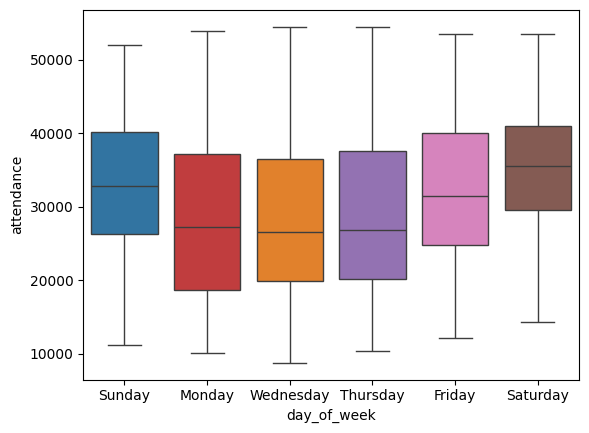

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns  


bb_temp = bb[bb.day_of_week != "Tuesda"]
ax = sns.boxplot(x="day_of_week", y="attendance", data=bb_temp, hue="day_of_week", order=["Sunday", "Monday", "Wednesday", "Thursday", "Friday", "Saturday"])
plt.show()

- We can see here that attendance on Friday, Saturday, and Sunday is on average higher than the other days of the week. 
- Therefore it may be beneficial to re-code this feature to either `Weekend` or `Weekday`.

## Scaling

- For quantitative features, it is important to think about how each feature is scaled. 
- Some features will be on vastly different scales than others just based on the nature of what the feature is measuring. 
- For example, let’s look at `temperature` and `total_runs` using the `.describe()` method:

In [88]:
bb.temperature = pd.to_numeric(bb.temperature, errors='coerce')
bb.total_runs = pd.to_numeric(bb.total_runs, errors='coerce')

bb.describe()

,attendance,temperature,total_runs
count,2460.000000,2462.000000,2462.000000
mean,30370.703659,73.820471,8.958164
std,9875.466703,10.584976,4.595667
min,8766.000000,31.000000,1.000000
25%,22432.000000,67.000000,6.000000
50%,30604.500000,74.000000,8.000000
75%,38396.250000,81.000000,12.000000
max,54449.000000,101.000000,60.000000


- These two features are on different scales because what they are measuring are different (`temperature` is in degrees Fahrenheit, `total_runs` is the number of runs scored in a game). 
- Because of this, the ranges of values and the standard deviations for each are very different from one another. 
- We can see here that `temperature` has a standard deviation of about 10.57, while `total_runs` has a standard deviation of about 4.58.

<br>

- When working with features with largely differing scales, it is often a good idea to *standardize* the features so that they all have a mean of 0 and a standard deviation of 1.
- A feature without any values close to zero may also make it more difficult to estimate and interpret the intercept of a regression model.
- Standardizing or otherwise re-scaling the feature can fix this issue.

## Missing Data

- When we initially inspected the data, we saw some evidence that missing data is coded in a few different ways:

In [89]:
bb[5:10]

,attendance,game_type,day_of_week,temperature,sky,total_runs
5,28386.0,Night Game,Tuesday,81.0,Cloudy,12.0
6,12757.0,Night Game,Tuesday,72.0,Unknown,NaN
7,28329.0,Night Game,Tuesday,NaN,Unknown,60.0
8,26049.0,Night Game,Tuesda,40.0,Sunny,11.0
9,10478.0,Night Game,Tuesday,70.0,Cloudy,9.0


- For example, temperature uses the term `Unknown`, `sky` uses both `Unknown` and `NaN`, and `total_runs` has - to represent a missing value.
- The observations with missing values will either have to be removed or replaced (with an imputed value or missing data type that Python can recognize, such as `np.NaN`) in order to proceed with fitting a regression model.

## Outliers

- In our EDA, it is important to check for outliers and skew in the data. One way to check for outliers is to use scatter plots:

<Axes: xlabel='total_runs', ylabel='attendance'>

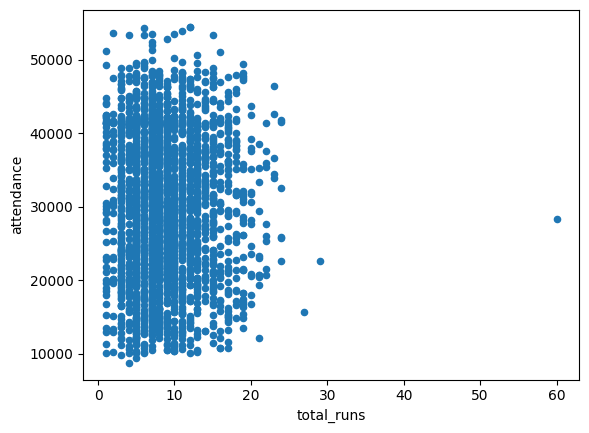

In [90]:
bb.plot.scatter(x = 'total_runs',y = 'attendance')

- We can see here that there is one instance where the total runs in a single game is about 60, which is much larger than in the other games. 
- Depending on the situation, we may first want to verify that this value is correct, then we can decide whether or not to remove it prior to fitting the model.

## Distributions and associations

- Prior to fitting a linear regression model, it can be important to inspect the distributions of quantitative features and investigate the relationships between features. 
- We can visually inspect both of these by using a pair plot:

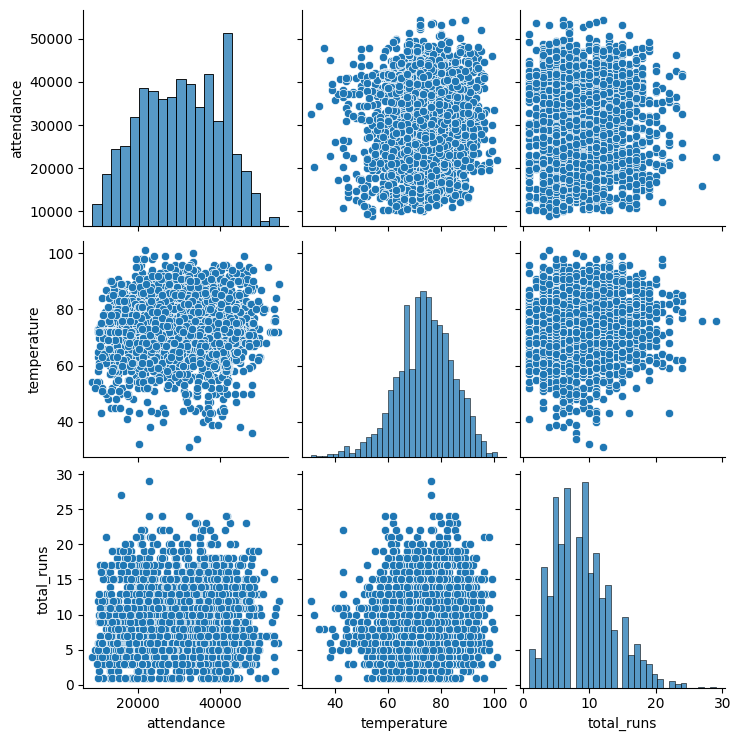

In [ ]:
# Change back the value from the beginning of the notebook
bb.loc[7, "total_runs"] = 7

sns.pairplot(bb)
plt.show()

- Looking at the histograms along the diagonal, `total_runs` appears to be somewhat right-skewed. 
- This indicates that we may want to transform this feature to make it more normally distributed.

<br>

- We can explore the relationships between pairs of features by looking at the scatterplots off of the diagonal. 
- This is useful for a few different reasons. 
- For example, if we see non-linear associations between any of the predictors and the outcome variable, that might lead us to test out polynomial terms in our model.
- We can also get a sense for which features are most highly related to our outcome variable and check for collinearity. 
- In this example, there appears to be a slight positive linear association between temperature and the total number of runs. 
- We can further investigate this using a heat map of the correlation matrix:

<Axes: >

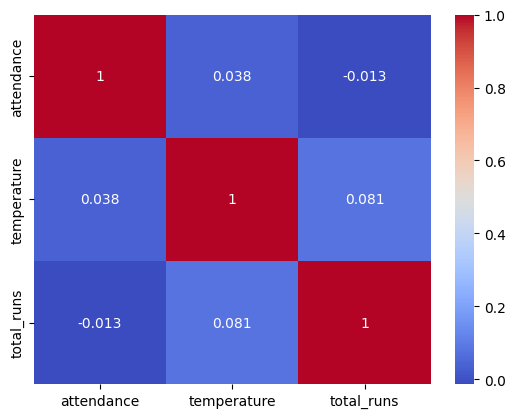

In [98]:
# heat map of the correlation matrix
sns.heatmap(bb[["attendance", "temperature", "total_runs"]].corr(), annot=True, cmap='coolwarm')

- There is a correlation of 0.081 between temperature and the total number of runs. 
- This is not large enough to cause concern; however, if two or more predictors are highly correlated, we may consider leaving only one in our analysis. 
- On the other hand, features that are highly correlated with our outcome variable are especially important to include in the model.

## Conclusion

- Let’s review the ways we were able to explore this data set in preparation for a regression model:
    - We previewed the first few rows of the data set using the `.head()` method.
    - We checked the data type of each variable in the data set using `.dtypes` and corrected variables with incorrect data types.
    - We investigated our categorical data to inform categorical encoding.
    - We investigated the scale of our quantitative variables and considered whether standardizing/scaling might be appropriate.
    - We investigated missing data.
    - We checked for outliers.
    - We inspected the distributions of our quantitative variables.
    - We looked at the relationships between pairs of features using both scatter plots and box plots.
- By going through these steps, we are more prepared to make decisions about feature selection/engineering and have learned valuable information about how to build a more accurate predictive model.